In [2]:
import pandas as pd
from functools import reduce

from analysis_modules import compute_accuracy, add_accuracy_diff, plot_metrics, analyze_errors, balance_df

---

## Determining Topic Controversy in the Dataset

<Axes: title={'center': 'Number of Questions per Topic'}, ylabel='topic'>

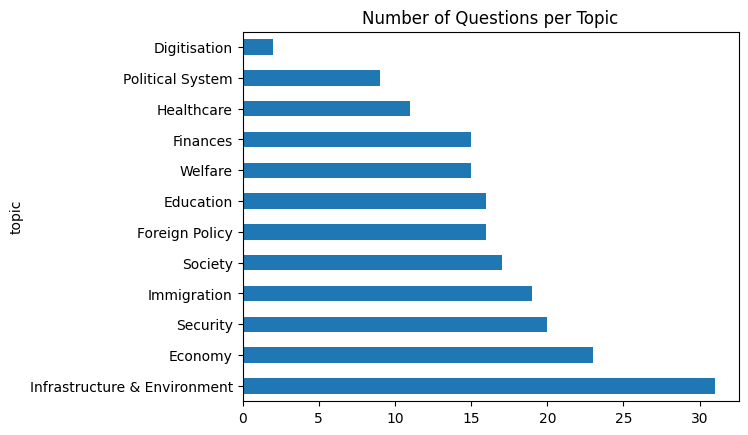

In [3]:
questions_en = pd.read_json('../data/xstance/questions.en.jsonl', lines=True)
questions_en['topic'].value_counts().plot(kind='barh', title='Number of Questions per Topic')

<Axes: title={'center': 'Number of Comments per Topic'}, ylabel='topic'>

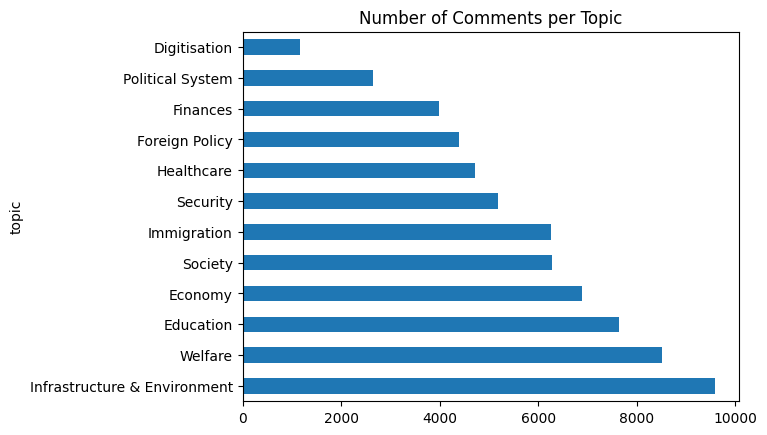

In [4]:
train = pd.read_json('../data/xstance/train.jsonl', lines=True)
valid = pd.read_json('../data/xstance/valid.jsonl', lines=True)
test = pd.read_json('../data/xstance/test.jsonl', lines=True)
all_data = pd.concat([train, valid, test])
all_data['topic'].value_counts().plot(kind='barh', title='Number of Comments per Topic')

<Axes: title={'center': 'Topic Controversy'}, ylabel='topic'>

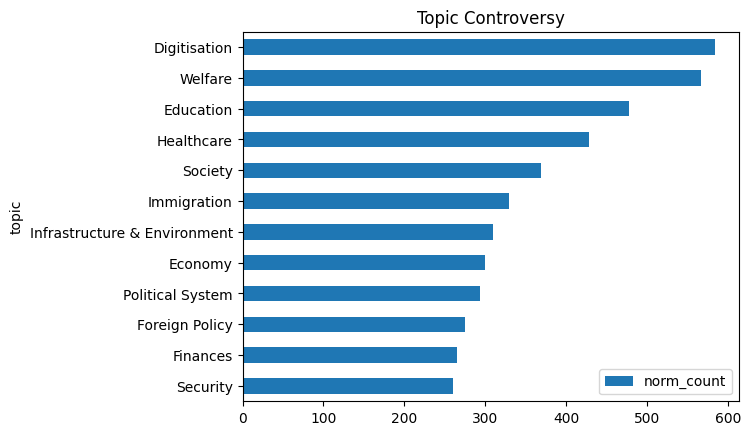

In [5]:
topic_q_counts = questions_en['topic'].value_counts().reset_index().rename(columns={'count': 'q_count'})
topic_cm_counts = all_data['topic'].value_counts().reset_index().rename(columns={'count': 'cm_count'})
topic_norm_counts = pd.merge(topic_q_counts, topic_cm_counts, on='topic').assign(norm_count=lambda x: round(x['cm_count'] / x['q_count'], 2)).sort_values('norm_count')
topic_norm_counts.plot(kind='barh', x='topic', y='norm_count', title='Topic Controversy')

<Axes: title={'center': 'Number of comments per question'}, xlabel='question_id'>

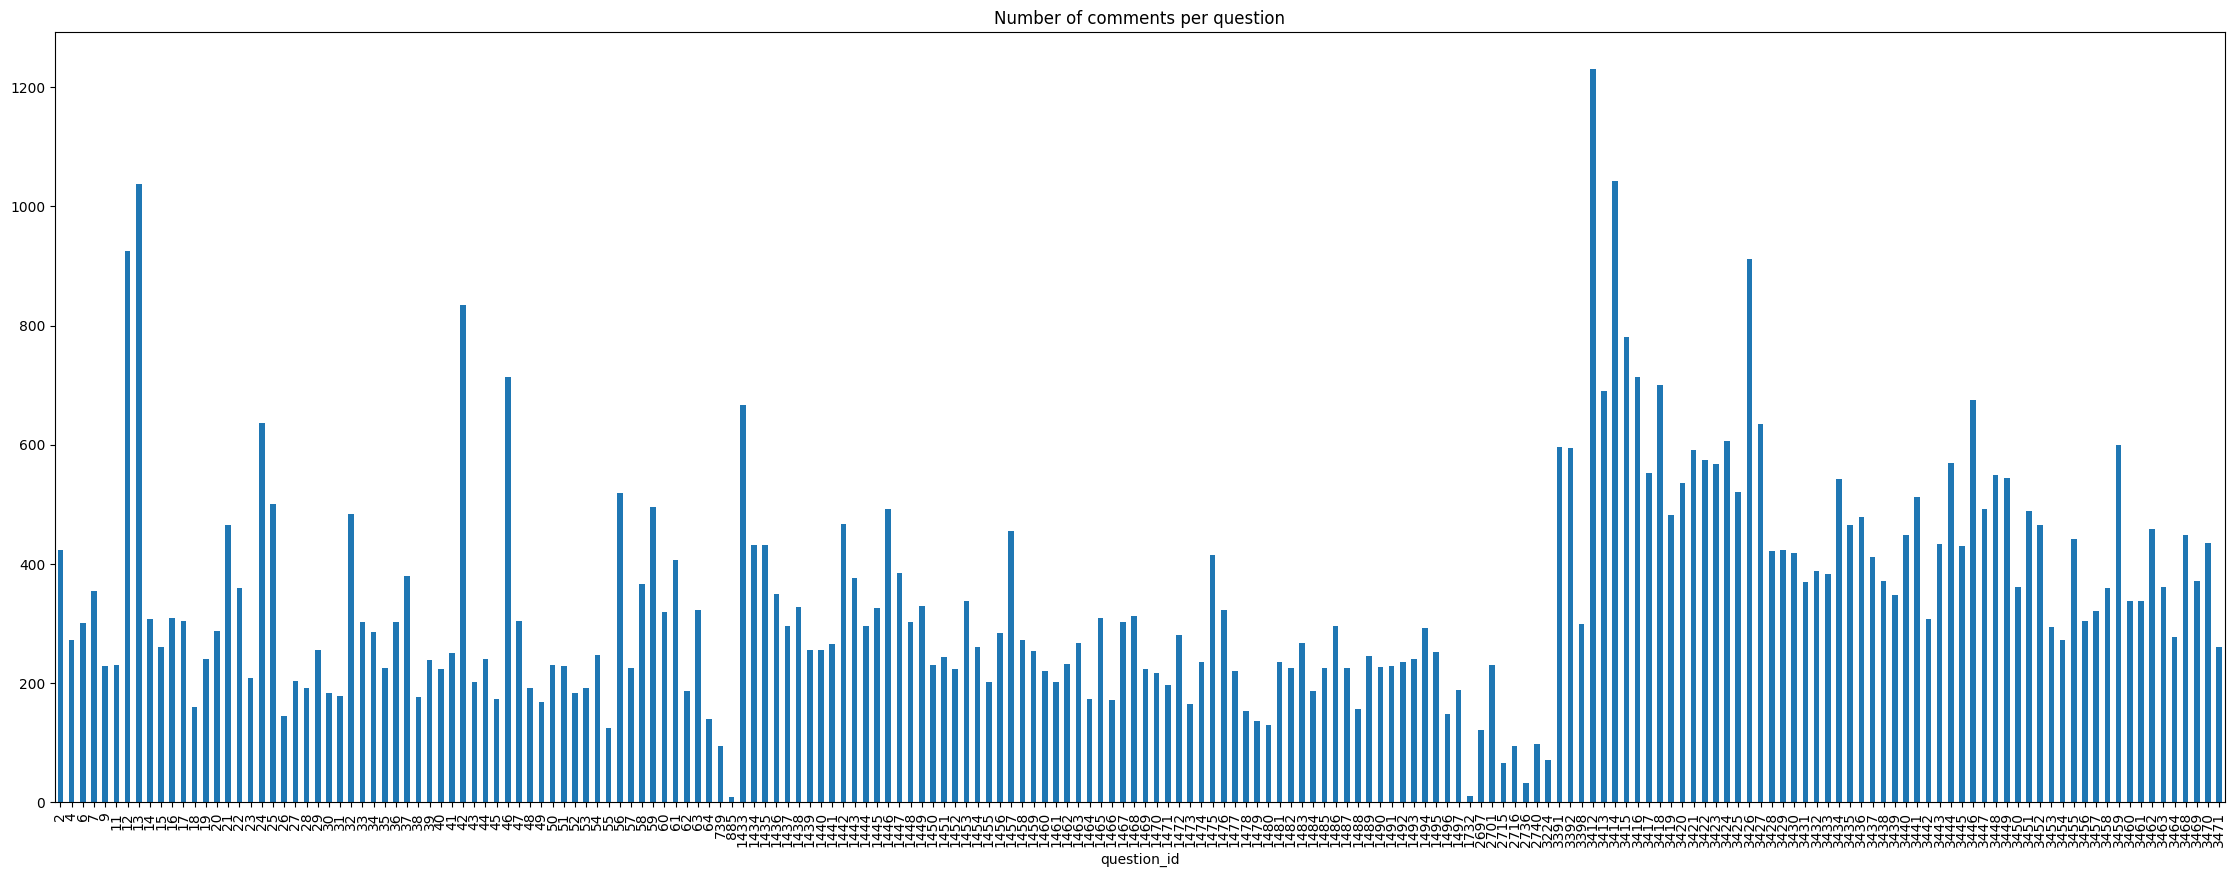

In [6]:
all_data.groupby('question_id')['comment'].count().plot(kind='bar', figsize=(28, 10), title="Number of comments per question")

In [7]:
all_data.groupby(['question_id', 'topic']).agg(
    n_FAVOR=('label', lambda x: (x == 'FAVOR').sum()),
    n_AGAINST = ('label', lambda x : (x == 'AGAINST').sum())
).reset_index()

,question_id,topic,n_FAVOR,n_AGAINST
0,2,Welfare,303,120
1,4,Welfare,144,128
2,6,Welfare,121,179
3,7,Healthcare,198,157
4,9,Healthcare,118,110
...,...,...,...,...
189,3464,Security,173,105
190,3468,Foreign Policy,138,311
191,3469,Foreign Policy,209,162
192,3470,Foreign Policy,246,189


---
## Binary

### Baseline

In [8]:
test = pd.read_json('../data/xstance/test.jsonl', lines=True)
baseline_acc = compute_accuracy(test, 'label', group_by='language', baseline=True)

### Fine-tuned

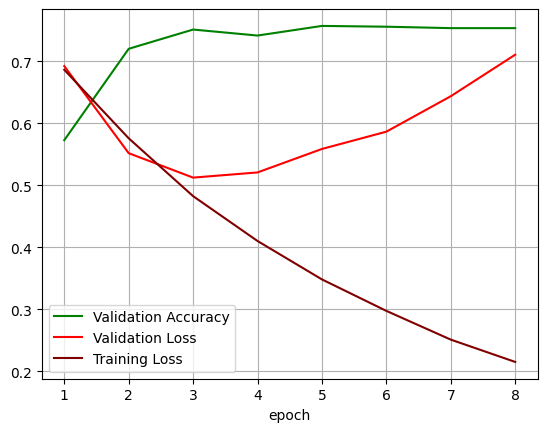

In [9]:
model_dir = "../models/xlmr+xstance"
plot_metrics(model_dir)

In [10]:
# Questions + comments
ft_preds = pd.read_csv('../predictions/on_xstance_test/xlmr+xstance_preds.csv')
ft_acc = compute_accuracy(ft_preds, 'label', 'prediction')

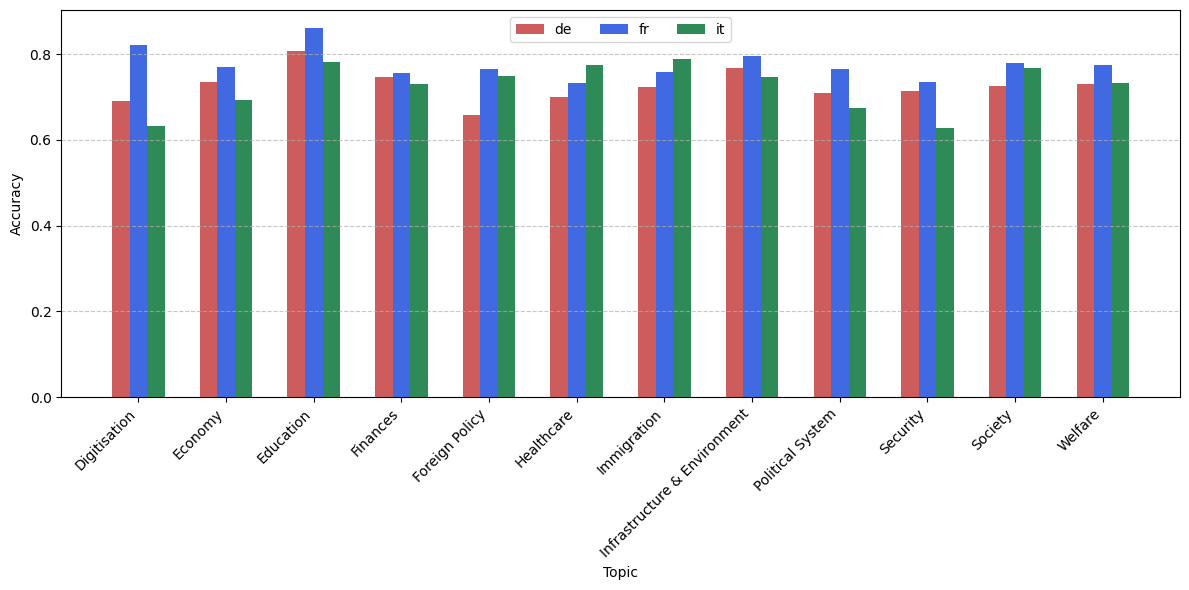

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_topic_language_performance(df, save_to=None):
    grouped_df = (df.groupby(['topic', 'language'])[['label', 'prediction']]
                    .apply(lambda x: (x['label'] == x['prediction']).mean())
                    .reset_index()
                    .pivot(index='topic', columns='language', values=0))

    topics = grouped_df.index
    languages = grouped_df.columns
    x = np.arange(len(topics))  # label locations
    width = 0.2  # bar width

    fig, ax = plt.subplots(figsize=(12, 6))
    colors = {'de': 'indianred', 'fr': 'royalblue', 'it': 'seagreen'}

    # Plot bars for each language
    for i, lang in enumerate(languages):
        ax.bar(x + i * width, grouped_df[lang], width, color=colors[lang], label=lang)

    ax.set_xlabel("Topic")
    ax.set_ylabel("Accuracy")
    # ax.set_title("Performance by Topic and Language")
    ax.set_xticks(x + width, topics, rotation=45, ha="right")
    ax.legend(loc='upper center', ncol=len(languages))
    ax.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    if save_to:
        plt.savefig(save_to, format="pdf")
    plt.show()


plot_topic_language_performance(ft_preds, save_to='../img/topic_lang_performance.pdf')

### Translated

In [12]:
de2fr_preds = pd.read_csv('../predictions/on_xstance_test/de2fr_preds.csv')
de2fr_acc = compute_accuracy(de2fr_preds, 'label', 'prediction')

fr2de_preds = pd.read_csv('../predictions/on_xstance_test/fr2de_preds.csv')
fr2de_acc = compute_accuracy(fr2de_preds, 'label', 'prediction')

it2fr_preds = pd.read_csv('../predictions/on_xstance_test/it2fr_preds.csv')
it2fr_acc = compute_accuracy(it2fr_preds, 'label', 'prediction')

it2de_preds = pd.read_csv('../predictions/on_xstance_test/it2de_preds.csv')
it2de_acc = compute_accuracy(it2de_preds, 'label', 'prediction')

translated_acc = pd.concat([de2fr_acc, fr2de_acc, it2fr_acc, it2de_acc]).reset_index(drop=True).rename(columns={'accuracy': 'acc_trans'})

In [13]:
de2fr2de_preds = pd.read_csv('../predictions/on_xstance_test/de2fr2de_preds.csv')
de2fr2de_acc = compute_accuracy(de2fr2de_preds, 'label', 'prediction').assign(trans_description='German → French → German')

fr2de2fr_preds = pd.read_csv('../predictions/on_xstance_test/fr2de2fr_preds.csv')
fr2de2fr_acc = compute_accuracy(fr2de2fr_preds, 'label', 'prediction').assign(trans_description='French → German → French')

it2fr2it_preds = pd.read_csv('../predictions/on_xstance_test/it2fr2it_preds.csv')
it2fr2it_acc = compute_accuracy(it2fr2it_preds, 'label', 'prediction').assign(trans_description='Italian → French → Italian')

it2de2it_preds = pd.read_csv('../predictions/on_xstance_test/it2de2it_preds.csv')
it2de2it_acc = compute_accuracy(it2de2it_preds, 'label', 'prediction').assign(trans_description='Italian → German → Italian')

round_trans_preds = pd.concat([de2fr2de_preds, fr2de2fr_preds, it2fr2it_preds, it2de2it_preds])
round_translated_acc = pd.concat([de2fr2de_acc, fr2de2fr_acc, it2fr2it_acc, it2de2it_acc]).reset_index(drop=True).rename(columns={'accuracy': 'acc_round-trans'})

In [14]:
joint_trans = pd.concat([translated_acc, round_translated_acc.drop(columns=['language'])], axis=1)

In [15]:
# All accuracies

all_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    baseline_acc.rename(columns={'accuracy': 'baseline(MFC)'}),
    ft_acc.rename(columns={'accuracy': 'acc_ft'}),
    joint_trans
])

add_accuracy_diff(all_acc, 'baseline(MFC)', diff_mode='previous')

,language,baseline(MFC),acc_ft,acc_trans,acc_round-trans,trans_description
0,de,50.53%,72.38% (+21.85%),67.02% (-5.36%),66.39% (-0.63%),German → French → German
1,fr,54.35%,76.58% (+22.23%),69.53% (-7.05%),69.21% (-0.32%),French → German → French
2,it,53.94%,73.58% (+19.64%),72.75% (-0.83%),69.09% (-3.66%),Italian → French → Italian
3,it,53.94%,73.58% (+19.64%),69.16% (-4.42%),67.77% (-1.39%),Italian → German → Italian


### Error Analysis
**Question:** How many times has the stance changed and in which direction?

In [16]:
ft_err_rates = analyze_errors(ft_preds, 'label', 'prediction', group_cols='language', compute_ci=True)
ft_err_rates

,language,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI
0,de,27.62,14.19,13.43,"[26.81, 28.42]","[13.56, 14.81]","[12.82, 14.04]"
1,fr,23.42,12.71,10.71,"[22.16, 24.68]","[11.72, 13.69]","[9.8, 11.63]"
2,it,26.42,13.83,12.59,"[24.15, 28.69]","[12.05, 15.61]","[10.88, 14.3]"


In [17]:
de2fr_err = analyze_errors(de2fr_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='German → French')
fr2de_err = analyze_errors(fr2de_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='French → German')
it2fr_err = analyze_errors(it2fr_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='Italian → French')
it2de_err = analyze_errors(it2de_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='Italian → German')

trans_err_rates = pd.concat([de2fr_err, fr2de_err, it2fr_err, it2de_err]).reset_index(drop=True)
trans_err_rates

,language,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI,trans_description
0,de,32.98,18.55,14.43,"[32.14, 33.83]","[17.85, 19.25]","[13.8, 15.06]",German → French
1,fr,30.47,17.35,13.12,"[29.11, 31.84]","[16.23, 18.48]","[12.12, 14.12]",French → German
2,it,27.25,14.45,12.79,"[24.95, 29.54]","[12.64, 16.27]","[11.07, 14.52]",Italian → French
3,it,30.84,16.18,14.66,"[28.46, 33.22]","[14.28, 18.08]","[12.84, 16.48]",Italian → German


In [18]:
de2fr2de_err = analyze_errors(de2fr2de_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='German → French → German')
fr2de2fr_err = analyze_errors(fr2de2fr_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='French → German → French')
it2fr2it_err = analyze_errors(it2fr2it_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='Italian → French → Italian')
it2de2it_err = analyze_errors(it2de2it_preds, 'label', 'prediction', group_cols='language', compute_ci=True).assign(trans_description='Italian → German → Italian')

round_trans_err_rates = pd.concat([de2fr2de_err, fr2de2fr_err, it2fr2it_err, it2de2it_err]).reset_index(drop=True)
round_trans_err_rates

,language,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI,trans_description
0,de,33.61,18.80,14.82,"[32.76, 34.46]","[18.09, 19.5]","[14.18, 15.46]",German → French → German
1,fr,30.79,16.96,13.83,"[29.42, 32.16]","[15.85, 18.08]","[12.8, 14.85]",French → German → French
2,it,30.91,17.77,13.14,"[28.53, 33.29]","[15.8, 19.74]","[11.4, 14.88]",Italian → French → Italian
3,it,32.23,19.50,12.72,"[29.82, 34.64]","[17.46, 21.54]","[11.01, 14.44]",Italian → German → Italian


In [19]:
ft_err = analyze_errors(ft_preds, 'label', 'prediction', group_cols=['question_id', 'topic'], compute_ci=True)
high_err_rate_ft = ft_err[ft_err['ErrRate (%)'] > 50]
n_comments = test[test['question_id'].isin(high_err_rate_ft['question_id'])].groupby('question_id')['comment'].count().reset_index().rename(columns={'comment': 'n_comments'})
high_err_rate_ft = pd.merge(high_err_rate_ft, n_comments, on='question_id')
high_err_rate_ft

,question_id,topic,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI,n_comments
0,54,Security,52.94,26.47,26.47,"[36.16, 69.72]","[11.64, 41.3]","[11.64, 41.3]",34
1,1488,Security,52.63,36.84,15.79,"[30.18, 75.08]","[15.15, 58.53]","[0, 32.19]",19
2,1490,Security,54.17,0.00,54.17,"[34.23, 74.1]","[0, 0.0]","[34.23, 74.1]",24


In [20]:
# Error rates of round translations
rt_err = analyze_errors(round_trans_preds, 'label', 'prediction', group_cols=['question_id', 'topic'], compute_ci=True)

# Questions with average error rates above 50%
high_err_rate_rt = rt_err[rt_err['ErrRate (%)'] > 50]
n_comments = test[test['question_id'].isin(high_err_rate_rt['question_id'])].groupby('question_id')['comment'].count().reset_index().rename(columns={'comment': 'n_comments'})
high_err_rate_rt = pd.merge(high_err_rate_rt, n_comments, on='question_id')
high_err_rate_rt

,question_id,topic,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI,n_comments
0,6,Welfare,54.29,37.14,17.14,"[37.78, 70.79]","[21.14, 53.15]","[4.66, 29.63]",29
1,26,Society,57.14,39.29,17.86,"[38.81, 75.47]","[21.2, 57.38]","[3.67, 32.04]",22
2,54,Security,53.49,23.26,30.23,"[38.58, 68.4]","[10.63, 35.88]","[16.51, 43.96]",34
3,1487,Security,54.29,28.57,25.71,"[37.78, 70.79]","[13.61, 43.54]","[11.23, 40.19]",28
4,1490,Security,55.17,6.90,48.28,"[37.07, 73.27]","[0, 16.12]","[30.09, 66.46]",24


In [21]:
# Accuracy of the round-translated inputs with respect to the finetuned model predictions
round_trans_preds = pd.concat([de2fr2de_preds, fr2de2fr_preds, it2fr2it_preds])
round_trans_preds = pd.merge(round_trans_preds, ft_preds[['id', 'prediction']].rename(columns={'prediction': 'ft_preds'}), on='id')
round_trans_acc_wrt_ft_acc = compute_accuracy(round_trans_preds, 'ft_preds', 'prediction')
round_trans_acc_wrt_ft_acc

,language,accuracy
0,de,0.737869
1,fr,0.757784
2,it,0.779391


In [22]:
# Error rates of the round-translated inputs with respect to the finetuned model predictions
rt_errors_wrt_ft = analyze_errors(round_trans_preds, 'ft_preds', 'prediction', group_cols='language', compute_ci=True)
rt_errors_wrt_ft['trans_description'] = ['German → French → German', 'French → German → French', 'Italian → French → Italian']
rt_errors_wrt_ft

,language,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI,trans_description
0,de,26.21,14.72,11.50,"[25.42, 27.0]","[14.08, 15.35]","[10.92, 12.07]",German → French → German
1,fr,24.22,12.68,11.54,"[22.95, 25.49]","[11.7, 13.67]","[10.59, 12.49]",French → German → French
2,it,22.06,12.72,9.34,"[19.92, 24.2]","[11.01, 14.44]","[7.84, 10.84]",Italian → French → Italian


In [23]:
# Cases where the round-translated predictions differ from the fine-tuned predictions
errors_wrt_ft = round_trans_preds[round_trans_preds['prediction'] != round_trans_preds['ft_preds']]
print('Where the round-translated predictions differ from the fine-tuned predictions,')

# Number of times the round-translated predictions were correct:
rt_correct = errors_wrt_ft[errors_wrt_ft['prediction'] == errors_wrt_ft['label']]
print('Number of times the round-translated predictions were correct:', len(rt_correct))

# Number of times the fine-tuned predictions were correct:
ft_correct = errors_wrt_ft[errors_wrt_ft['ft_preds'] == errors_wrt_ft['label']]
print('Number of times the fine-tuned predictions were correct:', len(ft_correct))

# Direction of misprediction
mispred_direction = analyze_errors(errors_wrt_ft, 'ft_preds', 'prediction', group_cols='language', compute_ci=True)
mispred_direction['trans_description'] = ['German → French → German', 'French → German → French', 'Italian → French → Italian']
mispred_direction

Where the round-translated predictions differ from the fine-tuned predictions,
Number of times the round-translated predictions were correct: 1697
Number of times the fine-tuned predictions were correct: 2797


,language,ErrRate (%),FP (%),FN (%),ErrRate_CI,FP_CI,FN_CI,trans_description
0,de,100.0,56.14,43.86,"[100.0, 100]","[54.4, 57.89]","[42.11, 45.6]",German → French → German
1,fr,100.0,52.36,47.64,"[100.0, 100]","[49.35, 55.37]","[44.63, 50.65]",French → German → French
2,it,100.0,57.68,42.32,"[100.0, 100]","[52.26, 63.1]","[36.9, 47.74]",Italian → French → Italian


In [24]:
for _, row in rt_correct[rt_correct['language'] == 'fr'].sample(5).iterrows():
    print(f"Original question: {test[test['id'] == row['id']]['question'].iloc[0]}")
    print(f"Original comment: {test[test['id'] == row['id']]['comment'].iloc[0]}")
    print(f"Back-translated question: {row['question']}")
    print(f"Back-translated comment: {row['comment']}")
    print(f"True label: {row['label']}")
    print(f"Finetuned model prediction: {row['ft_preds']}")
    print(f"Back-translated model prediction: {row['prediction']}")
    print()

Original question: Une vaccination obligatoire des enfants, basée sur le plan de vaccination suisse, devrait-elle être instaurée?
Original comment: Si le taux de vaccination baisse, il faudrait peut-être revoir ce plan. Mais le système actuel fonctionne.
Back-translated question: Faut-il imposer une vaccination obligatoire des enfants sur la base du programme de vaccination suisse ?
Back-translated comment: Si le taux de vaccination diminue, il se peut que nous devrions revoir ce plan, mais le système actuel fonctionne.
True label: AGAINST
Finetuned model prediction: FAVOR
Back-translated model prediction: AGAINST

Original question: Le financement des partis ainsi que celui des campagnes pour les élections et les votations devrait-il être transparent?
Original comment: Le financement de la vie politique repose sur des dons privés, de citoyens comme d'entreprises, qui doivent pouvoir le faire sans risquer que leur sphère privée soit remise en question.
Back-translated question: Le fina

In [25]:
for _, row in ft_correct[ft_correct['language'] == 'fr'].sample(5).iterrows():
    print(f"Original question: {test[test['id'] == row['id']]['question'].iloc[0]}")
    print(f"Original comment: {test[test['id'] == row['id']]['comment'].iloc[0]}")
    print(f"Back-translated question: {row['question']}")
    print(f"Back-translated comment: {row['comment']}")
    print(f"True label: {row['label']}")
    print(f"Finetuned model prediction: {row['ft_preds']}")
    print(f"Back-translated model prediction: {row['prediction']}")
    print()

Original question: À votre avis, l’application rigoureuse de l’initiative sur l’immigration de masse doit-elle avoir la priorité sur le maintien des accords bilatéraux conclus avec l’UE?
Original comment: Oui, l'accord de libre circulation entre la Suisse et l'UE doit être modifié. Depuis son introduction, tous les cantons frontaliers subissent une augmentation du chômage ainsi qu'une baisse de la progression des salaires. L'accord de libre circulation doit être réinventé : la libre circulation des personnes peut être maintenue si elle est combinée à un contingentement des travailleurs frontaliers.
Back-translated question: Selon vous, la stricte application de l'initiative d'immigration de masse devrait-elle être la priorité de maintenir les accords bilatéraux avec l'UE?
Back-translated comment: La libre circulation entre la Suisse et l'Union européenne doit être changée et, depuis son introduction, tous les pays frontaliers ont été touchés par une augmentation du chômage et une dimin

### Control for Topic

In [26]:
# ub_preds = pd.read_csv('../predictions/ub_preds.csv')
# filtered_train = pd.read_json('../data/xstance/filtered_train.jsonl', lines=True)
# ub_preds = ub_preds[ub_preds['topic'].isin(filtered_train['topic'].unique())]

# ub_acc = compute_accuracy(ub_preds, 'label', 'prediction')

# ub_bal = balance_df(ub_preds, ['language', 'label'])
# ub_bal_acc = compute_accuracy(ub_bal, 'label', 'prediction')

---
## Multi-class

### Baseline

In [27]:
multi_base_preds = pd.read_csv('../predictions/multi_baseline_preds.csv')
multi_base_acc = compute_accuracy(multi_base_preds, 'numerical_label', 'prediction')

FileNotFoundError: [Errno 2] No such file or directory: '../predictions/multi_baseline_preds.csv'

### Fine-tuned

In [ ]:
# Micro Average
# model_dir = "../models/multi_micro_stance_classifier/"
# plot_metrics(model_dir)

In [ ]:
multi_micro_preds = pd.read_csv('../predictions/multi_micro_preds.csv')
multi_micro_acc = compute_accuracy(multi_micro_preds, 'numerical_label', 'prediction')

In [ ]:
# Macro Average
# model_dir = "../models/multi_macro_stance_classifier/"
# plot_metrics(model_dir)

In [ ]:
multi_macro_preds = pd.read_csv('../predictions/multi_macro_preds.csv')
multi_macro_acc = compute_accuracy(multi_macro_preds, 'numerical_label', 'prediction')

In [ ]:
# All accuracies

multi_acc = reduce(lambda left, right: pd.merge(left, right, on='language'), [
    multi_base_acc.rename(columns={'accuracy': 'baseline'}),
    multi_micro_acc.rename(columns={'accuracy': 'finetuned_MicroAvg'}),
    multi_macro_acc.rename(columns={'accuracy': 'finetuned_MacroAvg'})
])
multi_acc

,language,baseline,finetuned_MicroAvg,finetuned_MacroAvg
0,de,0.282062,0.503574,0.494660
1,fr,0.304945,0.543040,0.523352
2,it,0.269018,0.508299,0.499308
